# HetRec 2011
---
The 2nd International Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec 2011, http://ir.ii.uam.es/hetrec2011) has released datasets from Delicious, Last.fm Web 2.0, MovieLens, IMDb, and Rotten Tomatoes. These datasets contain social networking, tagging, and resource consuming (Web page bookmarking and music artist listening) information from sets of around 2,000 users.

The datasets were generated by the Information Retrieval Group at Universidad Autónoma de Madrid (http://ir.ii.uam.es). Before using these datasets, please review the README files for the usage license and other details.

---
**MOVIES RECOMMENDER SYSTEM**

In [1]:
import numpy as np
import pandas as pd

import csv
import os

from tqdm.notebook import tqdm

from scipy.spatial.distance import cdist

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn

import fasttext
import fasttext.util

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

Perform recommendations using smaller Movielens dataset. This will allow to calculate recommendation quality measures.

In [2]:
SMALLER = True

# Data loading & correction
---

In [3]:
def dat_to_csv(dat_file, has_header=True, delimiter=',', save=False):
    with open(dat_file, 'r', encoding='cp437') as f:
        lines = f.read().split('\n')[:-1]
    
    if has_header:
        columns = lines[0].split(delimiter)
        lines = lines[1:]
    else:
        columns = [f'Column {i}' for i in range(len(lines[0].split(delimiter)))]
    
    df = pd.DataFrame(np.array([l.split(delimiter) for l in lines]), columns=columns)
    if save:
        df.to_csv(dat_file.replace('.dat', '.csv'))
    
    return df

## MovieLens + IMDb/Rotten Tomatoes dataset

In [4]:
df_ml_movies = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movies.dat', delimiter='\t')
df_ml_tags = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/tags.dat', delimiter='\t')
df_ml_moviegenres = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movie_genres.dat', delimiter='\t')
df_ml_usertagged = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_taggedmovies-timestamps.dat', delimiter='\t')
df_ml_userrated = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_ratedmovies-timestamps.dat', delimiter='\t')

In [5]:
df_ml_movies = df_ml_movies[['id', 'title']]
df_ml_movies.head()

,id,title
0,1,Toy story
1,2,Jumanji
2,3,Grumpy Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [6]:
df_ml_tags.head()

,id,value
0,1,earth
1,2,police
2,3,boxing
3,4,painter
4,5,whale


In [7]:
df_ml_moviegenres.head()

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [8]:
df_ml_usertagged = df_ml_usertagged[['userID', 'movieID', 'tagID']]
df_ml_usertagged.head()

,userID,movieID,tagID
0,75,353,5290
1,78,4223,5264
2,127,1343,1544
3,127,1343,12330
4,127,2080,1451


In [9]:
df_ml_userrated = df_ml_userrated[['userID', 'movieID', 'rating']]
df_ml_userrated.head()

,userID,movieID,rating
0,75,3,1
1,75,32,4.5
2,75,110,4
3,75,160,2
4,75,163,4


In [10]:
print(f'Movies: {len(df_ml_movies)}')
print(f'Tags: {len(df_ml_tags)}')
print(f'Genres: {len(df_ml_moviegenres)}')
print(f'Movies user taggings: {len(df_ml_usertagged)}')
print(f'Movies user ratings: {len(df_ml_userrated)}')

Movies: 10197
Tags: 13222
Genres: 20809
Movies user taggings: 47957
Movies user ratings: 855598


### Smaller movielens dataset
Reduce movies and users data to instances of given ids.

In [11]:
df_ml_moviegenres

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy
...,...,...
20804,65126,Comedy
20805,65126,Drama
20806,65130,Drama
20807,65130,Romance


In [12]:
if SMALLER:
    df_sml_movies = pd.read_csv('hetrec2011/ml-latest-small/movies.csv')
    sml_movie_ids = np.unique(df_sml_movies['movieId'].values).astype(str)
    
    df_sml_ratings = pd.read_csv('hetrec2011/ml-latest-small/ratings.csv')
    sml_user_r_ids = np.unique(df_sml_ratings['userId'].values)
    sml_user_t_ids = np.unique(df_sml_ratings['userId'].values)
    sml_user_ids = np.union1d(sml_user_r_ids, sml_user_t_ids).astype(str)
    
    # reduce appropriate dataframes
    df_ml_movies = df_ml_movies[df_ml_movies['id'].isin(sml_movie_ids)]
    df_ml_moviegenres = df_ml_moviegenres[df_ml_moviegenres['movieID'].isin(sml_movie_ids)]
    
    df_ml_usertagged = df_ml_usertagged[df_ml_usertagged['userID'].isin(sml_user_ids)]
    df_ml_usertagged = df_ml_usertagged[df_ml_usertagged['movieID'].isin(sml_movie_ids)]
    df_ml_userrated = df_ml_userrated[df_ml_userrated['userID'].isin(sml_user_ids)]
    df_ml_userrated = df_ml_userrated[df_ml_userrated['movieID'].isin(sml_movie_ids)]

In [13]:
np.unique(df_ml_userrated['userID'].values)

array(['127', '170', '175', '190', '267', '325', '383', '476', '477',
       '493', '498', '533', '545', '548', '580', '622', '636', '637',
       '75', '78'], dtype=object)

## Movies and users ids correction

First change indices data type from 'str' appropriately to 'np.int32' or 'np.float32'.

In [14]:
df_ml_userrated['userID'] = df_ml_userrated['userID'].astype(np.int32)
df_ml_userrated['movieID'] = df_ml_userrated['movieID'].astype(np.int32)
df_ml_userrated['rating'] = df_ml_userrated['rating'].astype(np.float32)

df_ml_usertagged['userID'] = df_ml_usertagged['userID'].astype(np.int32)
df_ml_usertagged['movieID'] = df_ml_usertagged['movieID'].astype(np.int32)
df_ml_usertagged['tagID'] = df_ml_usertagged['tagID'].astype(np.int32)

df_ml_movies['id'] = df_ml_movies['id'].astype(np.int32)

df_ml_tags['id'] = df_ml_tags['id'].astype(np.int32)

df_ml_moviegenres['movieID'] = df_ml_moviegenres['movieID'].astype(np.int32)

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [15]:
users = df_ml_userrated['userID'].values
items = df_ml_userrated['movieID'].values
ui_ratings = df_ml_userrated['rating'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Ratings: {len(ui_ratings)}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 20
Items: 2235
Ratings: 5172
Max user_id: 637
Max item_id: 64497


Maximum user index 71534 and item index 65133 are out of range: 2113 and 10109. Need to reset indices for rating prediction task.

In [16]:
user_mapping = dict(zip(np.unique(users), np.arange(n_users)))
item_mapping = dict(zip(np.unique(items), np.arange(n_items)))

In [17]:
user_rev_mapping = dict({v: k for k, v in user_mapping.items()})
item_rev_mapping = dict({v: k for k, v in item_mapping.items()})

In [18]:
df_ml_userrated['fixed_userID'] = df_ml_userrated['userID'].replace(user_mapping)
df_ml_userrated['fixed_movieID'] = df_ml_userrated['movieID'].replace(item_mapping)

In [19]:
users = df_ml_userrated['fixed_userID'].values
items = df_ml_userrated['fixed_movieID'].values
ui_ratings = df_ml_userrated['rating'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 20
Items: 2235
Max user_id: 19
Max item_id: 2234


Now it's ok.

# Movies recommendation
---
Aspects according to given user id:
- predicted movie ratings for user (matrix factorization / deep learning)
- movie genres similarity (content based approach)
- movie titles similarity (content based approach)
- movie user tagging similarity (collaborative filtering approach)
---
Let's perform movies recommendation for users 190 (new **5**) and 622 (new **17**).

In [20]:
USER01, USER02 = 190, 622

print(f'User {USER01} --> rating user: {user_mapping[USER01]}')
print(f'User {USER02} --> rating user: {user_mapping[USER02]}')

User 190 --> rating user: 5
User 622 --> rating user: 17


## Rating - Dense Feedforward NN

In [21]:
def user_ratings(user_id):
    df_common = df_ml_userrated.merge(df_ml_movies, left_on='movieID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['movieID', 'title', 'rating']]\
    .sort_values('rating', ascending=False)

In [22]:
df_user01_ratings = user_ratings(USER01)
df_user01_ratings

,movieID,title,rating
3059,8368,Harry Potter and the Prisoner of Azkaban,5.0
174,2571,The Matrix,5.0
342,260,Star Wars,5.0
1310,2761,The Iron Giant,5.0
2814,1967,Labyrinth,5.0
...,...,...,...
2223,8917,Team America: World Police,0.5
2798,1590,Event Horizon,0.5
2931,4148,Hannibal,0.5
2950,4734,Jay and Silent Bob Strike Back,0.5


In [23]:
df_user02_ratings = user_ratings(USER02)
df_user02_ratings

,movieID,title,rating
12,32,Twelve Monkeys,5.0
4593,56788,Charlie Wilson's War,5.0
2201,4963,Ocean's Eleven,5.0
4553,49772,The Painted Veil,5.0
2172,4011,Snatch.,5.0
...,...,...,...
2181,4306,Shrek,3.5
5071,688,Operation Dumbo Drop,3.0
5070,546,Super Mario Bros.,3.0
3539,54997,3:10 to Yuma,2.0


### Helpers

In [24]:
def batch(l, size):
    for i in range(0, len(l), size):
        yield l[i:i+size]

### Model

In [25]:
class DenseNet(torch.nn.Module):

    def __init__(self, n_users, n_items, n_factors, H1, D_out):
        """
        Simple Feedforward with Embeddings
        """
        super().__init__()
        # user and item embedding layers
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)
        # dropout after embeddings
        self.dropout1 = torch.nn.Dropout(0.1)
        # linear layers
        self.linear1 = torch.nn.Linear(n_factors*2, H1)
        self.linear2 = torch.nn.Linear(H1, H1)
        self.linear3 = torch.nn.Linear(H1, H1)
        self.linear4 = torch.nn.Linear(H1, D_out)
        # dropout after linear layers
        self.dropout2 = torch.nn.Dropout(0.1)

    def forward(self, users, items):
        users_embedding = self.user_factors(users)
        items_embedding = self.item_factors(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([users_embedding, items_embedding], 1)
        x = self.dropout1(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.dropout2(self.linear4(x))
        output_scores = torch.sigmoid(x)*5
        
        return output_scores

    def predict(self, users, items):
        # return the score
        output_scores = self.forward(users, items)
        return output_scores

In [26]:
class RatingPredictor():
    
    def __init__(self, user_ids, item_ids, ui_ratings, n_factors, h1):
        """
        Movie ratings predictor for all users.
        """
        self.user_ids = user_ids
        self.item_ids = item_ids
        
        self.ui_ratings = ui_ratings
        self.n_users = np.size(np.unique(user_ids))
        self.n_items = np.size(np.unique(item_ids))
        
        self.n_factors = n_factors
        self.h1 = h1
        
        self.__model = DenseNet(self.n_users, self.n_items, n_factors=self.n_factors, H1=self.h1, D_out=1)
        self.__loss = torch.nn.MarginRankingLoss()
        self.__optim = torch.optim.SGD(self.__model.parameters(), lr=1e-6)
        
    
    def fit(self, epochs, batch_size, save_progress=False):
        if save_progress:
            with open(f'hetrec2011/mr{fx}_prog_{self.n_factors}f_{self.h1}h.csv', 'w') as f:
                csv.writer(f).writerow(['epoch loss'])
        
        t = tqdm(range(epochs))
        for epoch in t:
            t.set_postfix_str(f'Epoch {epoch + 1}/{epochs}')
            us_b = batch(self.user_ids, size=batch_size)
            is_b = batch(self.item_ids, size=batch_size)
            uirs_b = batch(self.ui_ratings, size=batch_size)
            epoch_loss = 0
            
            tt = tqdm(zip(us_b, is_b, uirs_b),
                      total=int(np.size(self.ui_ratings)/batch_size + 1), leave=False)
            for u, i, uir in tt:
                # get user, item and rating data batch
                user = Variable(torch.LongTensor(u))
                item = Variable(torch.LongTensor(i))
                rating = Variable(torch.FloatTensor(uir))

                # predict
                prediction = self.__model(user, item)
                target = (prediction.reshape(-1) <= rating).int() - (prediction.reshape(-1) > rating).int()
                loss = self.__loss(prediction.reshape(-1), rating, target)
                epoch_loss += loss.detach().numpy()
                tt.set_postfix_str(f'Current MR loss: {np.round(np.float64(loss.detach().numpy()), 4)} ' +
                                   f'| Total: {np.round(epoch_loss, 4)}')

                # backpropagate
                loss.backward()

                # update weights
                self.__optim.step()
            
            #save current movie-rating progress step
            if save_progress:
                with open(f'hetrec2011/mr{fx}_prog_{self.n_factors}f_{self.h1}h.csv', 'a+') as f:
                    csv.writer(f).writerow([epoch_loss])
    
    def predict(self, user_id):
        user_id = user_mapping[user_id]
        users_tensor = torch.tensor([user_id]*np.size(self.item_ids))
        items_tensor = torch.tensor(self.item_ids)
        return self.__model(users_tensor, items_tensor).flatten().detach().numpy()

### Tests

In [27]:
BATCH_SIZE = 64
EPOCHS = 1

In [28]:
INPUT_FACTORS = 20
HIDDEN_FACTORS = 60

In [29]:
fx = '_smaller' if SMALLER else ''
RP_MODEL_PATH = f'hetrec2011/rp{fx}_model_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h'

In [30]:
df_userrated_titles = df_ml_userrated.merge(df_ml_movies, left_on='movieID', right_on='id')
df_userrated_titles

,userID,movieID,rating,fixed_userID,fixed_movieID,id,title
0,75,3,1.0,0,2,3,Grumpy Old Men
1,75,32,4.5,0,21,32,Twelve Monkeys
2,78,32,5.0,1,21,32,Twelve Monkeys
3,170,32,4.0,3,21,32,Twelve Monkeys
4,175,32,4.0,4,21,32,Twelve Monkeys
...,...,...,...,...,...,...,...
5167,636,54276,3.0,18,2162,54276,No Reservations
5168,636,55765,3.5,18,2179,55765,American Gangster
5169,636,58303,3.5,18,2210,58303,Die FΣlscher
5170,636,59421,2.5,18,2221,59421,What Happens in Vegas


In [31]:
if not os.path.exists(RP_MODEL_PATH):
    rp = RatingPredictor(
        df_userrated_titles['fixed_userID'].values,
        df_userrated_titles['fixed_movieID'].values,
        df_userrated_titles['rating'].values,
        n_factors=INPUT_FACTORS, h1=HIDDEN_FACTORS)
    rp.fit(epochs=EPOCHS, batch_size=BATCH_SIZE, save_progress=True)
    torch.save(rp, RP_MODEL_PATH)
else:
    rp = torch.load(RP_MODEL_PATH)

In [32]:
def prediction_quality_plot(input_file, title, save_file=None):
    df = pd.read_csv(input_file)
    
    plt.plot(df.index + 1, df['epoch loss'], label='epoch margin ranking loss')
    plt.scatter(df.index + 1, df['epoch loss'])
    plt.xticks(df.index + 1)
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    for k, v in zip(df.index + 1, df['epoch loss']):
        plt.annotate(np.round(v, 4), (k, v), size=16, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(loc='best')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

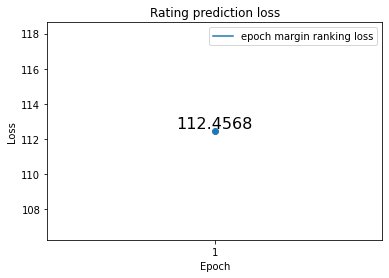

In [33]:
prediction_quality_plot(input_file=f'hetrec2011/mr{fx}_prog_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.csv',
                        title='Rating prediction loss',
                        save_file=f'hetrec2011/rating_prediction{fx}_loss_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.png')

In [34]:
def ratings_recommendations(df, predictions):
    df_all = pd.DataFrame({
        'movieID': df['movieID'].values,
        'title': df['title'].values,
        'pred. rating': predictions
    }).drop_duplicates()
    
    df_all = df_all.groupby(['movieID', 'title'])['pred. rating'].apply(np.max).to_frame().reset_index()
    
    return df_all.sort_values('pred. rating', ascending=False)

In [35]:
df_user01_ratings_recommendations = ratings_recommendations(df_userrated_titles, rp.predict(USER01))
df_user01_ratings_recommendations

,movieID,title,pred. rating
1744,7247,Chitty Chitty Bang Bang,2.521984
1648,6774,Videodrome,2.505054
1903,26163,Dont Look Back,2.504198
1550,6001,The King of Comedy,2.503627
669,2076,Blue Velvet,2.501726
...,...,...,...
1029,3219,Pacific Heights,2.337314
1759,7360,Dawn of the Dead,2.336756
257,849,Escape from L.A.,2.335814
56,163,Desperado,2.334264


In [36]:
df_user02_ratings_recommendations = ratings_recommendations(df_userrated_titles, rp.predict(USER02))
df_user02_ratings_recommendations

,movieID,title,pred. rating
0,1,Toy story,2.500000
1068,3365,The Searchers,2.500000
1071,3391,Who's That Girl,2.500000
385,1223,A Grand Day Out with Wallace and Gromit,2.500000
383,1221,The Godfather: Part II,2.500000
...,...,...,...
1320,4464,The Accidental Tourist,2.348584
1447,5303,Joe Versus the Volcano,2.347510
1934,30749,Hotel Rwanda,2.343614
1008,3158,Jing Ke ci Qin Wang,2.338246


## Genres - Content Based Approach

Each movie has a list of assigned genres. Task is to calculate Jaccard similarity for each movie to each i.e. to construct Jaccard similarity matrix.

In [37]:
genres = np.unique(df_ml_moviegenres['genre'])
genres

array(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype=object)

In [38]:
# first aggregate (to numpy array) movie genres dataframe by movieID
srs_moviegenres = df_ml_moviegenres.groupby('movieID')['genre'].apply(np.array).values
srs_moviegenres

array([array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
      dtype=object),
       array(['Adventure', 'Children', 'Fantasy'], dtype=object),
       array(['Comedy', 'Romance'], dtype=object), ...,
       array(['Comedy', 'Drama'], dtype=object),
       array(['Drama', 'Romance'], dtype=object),
       array(['Comedy'], dtype=object)], dtype=object)

In [39]:
# build zero-one genres dataframe
df_moviegenres_zeroone = pd.DataFrame([{g: 1 if g in mgs else 0 for g in genres} for mgs in srs_moviegenres])
df_moviegenres_zeroone

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6809,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6810,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6811,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6812,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [40]:
jaccard_mtx = cdist(df_moviegenres_zeroone, df_moviegenres_zeroone, 'jaccard')
jaccard_mtx = np.subtract(np.ones(jaccard_mtx.shape), jaccard_mtx)

df_jaccard_sim = pd.DataFrame(jaccard_mtx,
                              index=df_ml_movies['id'].values,
                              columns=df_ml_movies['id'].values)
df_jaccard_sim

,1,2,3,4,5,6,7,8,9,10,...,64969,64983,64990,64993,64997,65037,65088,65126,65130,65133
1,1.000000,0.6,0.166667,0.142857,0.200000,0.0,0.166667,0.400000,0.0,0.142857,...,0.200000,0.000000,0.0,0.142857,0.0,0.000000,0.600000,0.166667,0.000000,0.200000
2,0.600000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.0,0.200000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.500000,0.000000,0.000000,0.000000
3,0.166667,0.0,1.000000,0.666667,0.500000,0.0,1.000000,0.000000,0.0,0.000000,...,0.500000,0.000000,0.0,0.250000,0.0,0.000000,0.250000,0.333333,0.333333,0.500000
4,0.142857,0.0,0.666667,1.000000,0.333333,0.0,0.666667,0.000000,0.0,0.000000,...,0.333333,0.200000,0.0,0.500000,0.0,0.333333,0.200000,0.666667,0.666667,0.333333
5,0.200000,0.0,0.500000,0.333333,1.000000,0.0,0.500000,0.000000,0.0,0.000000,...,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.333333,0.500000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65037,0.000000,0.0,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.333333,0.0,0.333333,0.0,1.000000,0.000000,0.500000,0.500000,0.000000
65088,0.600000,0.5,0.250000,0.200000,0.333333,0.0,0.250000,0.666667,0.0,0.200000,...,0.333333,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.250000,0.000000,0.333333
65126,0.166667,0.0,0.333333,0.666667,0.500000,0.0,0.333333,0.000000,0.0,0.000000,...,0.500000,0.250000,0.0,0.250000,0.0,0.500000,0.250000,1.000000,0.333333,0.500000
65130,0.000000,0.0,0.333333,0.666667,0.000000,0.0,0.333333,0.000000,0.0,0.000000,...,0.000000,0.250000,0.0,0.666667,0.0,0.500000,0.000000,0.333333,1.000000,0.000000


In [41]:
N_HIGHEST = 10

Take **N_HIGHEST** user movie ratings and then for each taken movie calculate jaccards similarities. Stack them vertically and calculate summaric similarity aggregating by 'movieID'.

In [42]:
def users_genres_most_similar(df, n_highest=N_HIGHEST):
    df_highest = df[:n_highest][['movieID']]
    
    df_all = pd.DataFrame(columns=df_highest.columns)
    
    for i, row in df_highest.iterrows():
        sims = df_jaccard_sim[int(row['movieID'])].values
        df_sims = pd.DataFrame({
            'movieID': df_jaccard_sim.index,
            's': sims
        })
        
        df_all = pd.concat([df_all, df_sims])
    
    df_all = df_all.groupby('movieID')['s'].apply(np.sum)
    
    df_all = pd.DataFrame({
        'movieID': df_all.index,
        'sum sim.': df_all.values
    })
    
    return df_all.merge(df_ml_movies, left_on='movieID', right_on='id')[['movieID', 'title', 'sum sim.']]\
                 .sort_values('sum sim.', ascending=False)

In [43]:
df_user01_genres_similarities = users_genres_most_similar(df_user01_ratings)
df_user01_genres_similarities

,movieID,title,sum sim.
4169,5540,Clash of the Titans,5.842857
3376,4275,Krull,5.842857
42,44,Mortal Kombat,5.842857
4756,6743,The Jungle Book,5.842857
3880,5039,Dragonslayer,5.842857
...,...,...,...
1459,1903,Hav Plenty,0.000000
1464,1911,Doctor Dolittle,0.000000
3989,5229,I Think I Do,0.000000
5287,8011,The Weather Underground,0.000000


In [44]:
df_user02_genres_similarities = users_genres_most_similar(df_user02_ratings)
df_user02_genres_similarities

,movieID,title,sum sim.
2607,3266,C'est arrivΘ prΦs de chez vous,3.85
532,608,Fargo,3.85
6157,42900,Cul-de-sac,3.85
831,1034,Freeway,3.85
6460,53322,Ocean's Thirteen,3.85
...,...,...,...
3066,3859,The Eyes of Tammy Faye,0.00
6339,49132,Shut Up & Sing,0.00
5287,8011,The Weather Underground,0.00
5290,8015,The Phantom Tollbooth,0.00


## Titles - Content Based Approach

Each movie has a title. Task is to calculate cosine similarity of vectorized titles.

In [45]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [46]:
titles = df_ml_movies['title'].values
titles_embeddings = np.array([ft_model[t] for t in titles])

In [47]:
del ft_model

In [48]:
cosine_mtx = cdist(titles_embeddings, titles_embeddings, 'cosine')
cosine_mtx = np.subtract(np.ones(cosine_mtx.shape), cosine_mtx)

df_cosine_sim = pd.DataFrame(cosine_mtx,
                             index=df_ml_movies['id'].values,
                             columns=df_ml_movies['id'].values)
df_cosine_sim

,1,2,3,4,5,6,7,8,9,10,...,64969,64983,64990,64993,64997,65037,65088,65126,65130,65133
1,1.000000,-0.043924,0.254355,0.322977,0.068773,-0.043023,0.025546,0.150753,0.139382,0.002632,...,0.119686,0.091820,0.293527,0.278953,0.180460,0.033936,0.191460,-0.056620,0.223498,0.177634
2,-0.043924,1.000000,0.025938,0.105813,0.042646,0.194687,0.194283,0.168683,0.042247,0.329911,...,-0.043479,0.196505,0.056532,0.071936,0.078574,0.026990,0.045645,0.183267,0.019522,0.105598
3,0.254355,0.025938,1.000000,0.476239,0.291594,0.102405,0.165065,0.323610,0.258272,0.004917,...,0.138952,0.048027,0.494974,0.362199,0.418594,-0.028020,0.314664,0.025119,0.353919,0.400596
4,0.322977,0.105813,0.476239,1.000000,0.411442,0.189339,0.064835,0.329333,0.363486,0.109441,...,0.062320,0.146112,0.573110,0.398801,0.432929,0.040599,0.446627,0.146824,0.459336,0.443977
5,0.068773,0.042646,0.291594,0.411442,1.000000,0.066673,0.080009,0.327017,0.404592,0.040607,...,0.002426,0.087391,0.492590,0.304724,0.567281,0.076673,0.367735,0.113340,0.266810,0.307080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65037,0.033936,0.026990,-0.028020,0.040599,0.076673,0.037909,0.014099,-0.028702,0.024429,-0.041598,...,0.116611,0.024978,-0.002091,0.058039,0.020661,1.000000,-0.086122,-0.070498,-0.013896,0.074998
65088,0.191460,0.045645,0.314664,0.446627,0.367735,0.124570,0.043616,0.199498,0.429269,0.003768,...,0.060265,0.091374,0.422847,0.234755,0.307136,-0.086122,1.000000,0.060827,0.318255,0.203941
65126,-0.056620,0.183267,0.025119,0.146824,0.113340,0.321504,0.083696,0.188321,0.106621,0.179827,...,-0.073102,0.188121,0.142218,-0.001647,0.000244,-0.070498,0.060827,1.000000,0.054269,0.068604
65130,0.223498,0.019522,0.353919,0.459336,0.266810,0.064338,0.015603,0.329389,0.358824,0.001381,...,0.119034,0.101143,0.569168,0.387998,0.425379,-0.013896,0.318255,0.054269,1.000000,0.464840


Take **N_HIGHEST** user movie ratings and then for each taken movie calculate cosine similarities. Stack them vertically and calculate summaric similarity aggregating by 'movieID'.

In [49]:
def users_titles_most_similar(df, n_highest=N_HIGHEST):
    df_highest = df[:n_highest][['movieID']]
    
    df_all = pd.DataFrame(columns=df_highest.columns)
    
    for i, row in df_highest.iterrows():
        sims = df_cosine_sim[int(row['movieID'])].values
        df_sims = pd.DataFrame({
            'movieID': df_jaccard_sim.index,
            's': sims
        })
        
        df_all = pd.concat([df_all, df_sims])
    
    df_all = df_all.groupby('movieID')['s']\
                   .apply(np.sum)
    
    df_all = pd.DataFrame({
        'movieID': df_all.index,
        'sum sim.': df_all.values
    })
    
    return df_all.merge(df_ml_movies, left_on='movieID', right_on='id')[['movieID', 'title', 'sum sim.']]\
                 .sort_values('sum sim.', ascending=False)

In [50]:
df_user01_titles_similarities = users_titles_most_similar(df_user01_ratings)
df_user01_titles_similarities

,movieID,title,sum sim.
1665,2116,The Lord of the Rings: The Return of the King,5.068933
5001,7153,The Lord of the Rings: The Return of the King,5.068933
5371,8368,Harry Potter and the Prisoner of Azkaban,5.036038
4371,5952,The Lord of the Rings: The Two Towers,5.032755
3849,4993,The Lord of the Rings: The Fellowship of the Ring,4.982283
...,...,...,...
3548,4531,Red Heat,0.000380
995,1251,8╜,0.000000
2894,3656,Lured,-0.106866
5800,27674,11:14,-0.174519


In [51]:
df_user02_titles_similarities = users_titles_most_similar(df_user02_ratings)
df_user02_titles_similarities

,movieID,title,sum sim.
3715,4769,Into the Arms of Strangers: Stories of the Kin...,5.266466
5948,32582,The Wild Parrots of Telegraph Hill,5.215727
2393,2998,Dreaming of Joseph Lees,5.212084
5527,8830,Anacondas: The Hunt for the Blood Orchid,5.197557
4746,6722,Wong Fei Hung II: Nam yi dong ji keung,5.178831
...,...,...,...
2894,3656,Lured,-0.038121
5013,7172,Uzak,-0.057381
5800,27674,11:14,-0.111052
3784,4887,The One,-0.199028


## User tagging - Collaborative Filtering Approach

Some certain movies have some certain user taggings. Group user tagging by movie and then calculate the mean of cosine similarities for each vectorized tags pair. At the end take maximum movie tagging values (group by movies).

In [52]:
srs_user_taglists = df_ml_usertagged.merge(df_ml_tags, left_on='tagID', right_on='id', how='left')\
                                    .drop(['tagID', 'id'], axis=1).groupby(['userID', 'movieID'])['value']\
                                    .apply(lambda x: ', '.join(np.sort(x)))
srs_uid, srs_mid = np.array([*srs_user_taglists.index]).T
df_user_taglists = pd.DataFrame({
    'userID': srs_uid,
    'movieID': srs_mid,
    'tags': srs_user_taglists.values
})
del srs_uid, srs_mid
df_user_taglists = df_user_taglists.merge(df_ml_movies, left_on='movieID', right_on='id', how='left')\
                                   .drop('id', axis=1)
df_user_taglists[['userID', 'movieID', 'title', 'tags']]  # tags must be ordered ascendingly

,userID,movieID,title,tags
0,75,353,The Crow,tissit
1,78,4223,Enemy at the Gates,want to own
2,127,1343,Cape Fear,"killer, stalker"
3,127,2080,Lady and the Tramp,"dogs, romantic"
4,127,2953,Home Alone 2: Lost in New York,"alone, robbers"
...,...,...,...,...
138,636,1233,Das Boot,"hunt, hunted, submarine"
139,636,1876,Deep Impact,"astronomy, catastrophy, comet, disaster, threat"
140,636,2993,Thunderball,"agent, bond, nuclear bomb, under water"
141,636,4993,The Lord of the Rings: The Fellowship of the Ring,magic


In [53]:
def user_taggings(user_id):
    df_common = df_user_taglists.merge(df_ml_movies.drop('title', axis=1), left_on='movieID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['movieID', 'title', 'tags']]

In [54]:
df_user01_taggings = user_taggings(USER01)
df_user01_taggings.head(10)

,movieID,title,tags
16,741,K⌠kaku kid⌠tai,anime
17,1274,Akira,anime
19,2116,The Lord of the Rings: The Return of the King,high fantasy
20,2810,Perfect Blue,anime
21,3000,Mononoke-hime,anime
22,3997,Dungeons & Dragons,high fantasy
23,4993,The Lord of the Rings: The Fellowship of the Ring,high fantasy
25,5039,Dragonslayer,high fantasy
26,5069,Escaflowne,anime
27,5072,Metropolis,anime


In [55]:
df_user02_taggings = user_taggings(USER02)
df_user02_taggings.head(10)

,movieID,title,tags
49,628,Primal Fear,"crime, drama, edward norton"
69,32587,Sin City,frank miller
85,48043,The Fountain,"immortality, inspirational, life through death..."
93,32,Twelve Monkeys,"brad pitt, bruce willis, time travel"
94,47,Shichinin no samurai,"brad pitt, serial killer"
95,165,Die Hard: With a Vengeance,"action, bruce willis, samuel l jackson"
96,231,Dumb & Dumber,"jeff daniels, jim carrey, stupid"
97,377,Speed,"keanu reeves, sandra bullock"
98,442,Demolition Man,"dystopia, sylvester stallone, wesley snipes"
99,593,The Silence of the Lambs,anthony hopkins


In [56]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [57]:
tags = df_user_taglists['tags'].values
taglists_embeddings = np.array([ft_model[t] for t in tags])

tags01 = df_user01_taggings['tags'].values
user01_taglists_embeddings = np.array([ft_model[t] for t in tags01])

tags02 = df_user02_taggings['tags'].values
user02_taglists_embeddings = np.array([ft_model[t] for t in tags02])

In [58]:
del ft_model

In [59]:
def users_taggings_most_similar(df, embeddings):
    
    cosine_sims = cdist(taglists_embeddings, embeddings, 'cosine')
    cosine_sims = np.subtract(np.ones(cosine_sims.shape), cosine_sims)
    mean_sims = np.mean(cosine_sims, axis=1)
    
    df_all = pd.DataFrame(df_user_taglists)
    df_all['sum sim.'] = mean_sims
    
    sums = df_all.groupby(['movieID', 'title'])['sum sim.'].apply(np.sum).to_frame().reset_index()
    
    # reduce to single movies with highest similarity score
    single_titles = sums[['movieID', 'title', 'sum sim.']].groupby(['movieID', 'title'])['sum sim.']\
                                                           .apply(np.max).to_frame().reset_index()
    
    return single_titles.sort_values('sum sim.', ascending=False)

In [60]:
df_user01_taggings_similarities = users_taggings_most_similar(df_user01_taggings, user01_taglists_embeddings)
df_user01_taggings_similarities

,movieID,title,sum sim.
25,1274,Akira,0.891733
70,5618,Sen to Chihiro no kamikakushi,0.852927
73,5690,Hotaru no haka,0.789862
11,741,K⌠kaku kid⌠tai,0.789862
99,31658,Hauru no ugoku shiro,0.789862
...,...,...,...
109,45210,United 93,0.004188
102,33154,Enron: The Smartest Guys in the Room,0.004188
96,27834,Vozvrashchenie,0.004188
88,7566,28 Up,0.004188


In [61]:
df_user02_taggings_similarities = users_taggings_most_similar(df_user02_taggings, user02_taglists_embeddings)
df_user02_taggings_similarities

,movieID,title,sum sim.
10,628,Primal Fear,1.019485
86,7147,Big Fish,0.883710
101,32587,Sin City,0.789628
112,48043,The Fountain,0.689453
84,6934,The Matrix Revolutions,0.584776
...,...,...,...
83,6857,J√bΩ ninp√ch⌠,0.061876
75,5971,Tonari no Totoro,0.061876
94,27728,Innocence,0.061876
23,1244,Manhattan,0.041207


## Hybrid recommendation

Perform an outer merge of movie predicted ratings and similarities dataframes and calculate recommendation ratio.

Columns:
- **movieID** - movie id
- **title** - movie title
- **pred. rating** - predicted movie ratings
- **genres sim.** - total genres jaccard similarity of **N_HIGHEST** rated movies
- **titles sim.** - total titles cosine similarity of **N_HIGHEST** rated movies
- **tags sim.** - total tagging cosine similarity of all user taggings (max values)
- **sc. ...** - scaled to 0-1 given value
- **ratio** - general recommender system ratio {**40%** rating, **40%** genres, **10%** titles, **10%** tags}

In [62]:
def hybrid_recommendation(df_ratings, df_genres_sims, df_title_sims, df_tags_sims, save_file=None):
    df_hybrid = df_ratings.merge(df_genres_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'genres sim.'})\
                         .drop('title_y', axis=1)
    
    df_hybrid = df_hybrid.merge(df_title_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'titles sim.'})\
                         .drop('title_y', axis=1)
    
    df_hybrid = df_hybrid.merge(df_tags_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'tags sim.'})\
                         .drop('title_y', axis=1)
    
    # replace NaN values
    df_hybrid = df_hybrid.fillna(0.)
    
    # scale all 4 measures to 0-1 interval
    mn, mx = df_hybrid['pred. rating'].min(), df_hybrid['pred. rating'].max()
    df_hybrid['sc. rating'] = (df_hybrid['pred. rating'] - mn)/(mx - mn)
    mn, mx = df_hybrid['genres sim.'].min(), df_hybrid['genres sim.'].max()
    df_hybrid['sc. genres'] = (df_hybrid['genres sim.'] - mn)/(mx - mn)
    mn, mx = df_hybrid['titles sim.'].min(), df_hybrid['titles sim.'].max()
    df_hybrid['sc. titles'] = (df_hybrid['titles sim.'] - mn)/(mx - mn)
    mn, mx = df_hybrid['tags sim.'].min(), df_hybrid['tags sim.'].max()
    df_hybrid['sc. tags'] = (df_hybrid['tags sim.'] - mn)/(mx - mn)
    
    # finally (40%:40%:10%:10%)
    df_hybrid['ratio'] = df_hybrid.apply(lambda x: 0.4*x['sc. rating'] +
                                         0.4*x['sc. genres'] +0.1*x['sc. titles'] + 0.1*x['sc. tags'],
                                         axis=1)
    df_hybrid = df_hybrid.sort_values('ratio', ascending=False)
    
    if save_file:
        df_hybrid.to_csv(save_file, index=False)
    
    return df_hybrid

In [63]:
df_user01_hr = hybrid_recommendation(df_user01_ratings_recommendations, df_user01_genres_similarities,
                                     df_user01_titles_similarities, df_user01_taggings_similarities,
                                     save_file=f'hetrec2011/user{USER01}{fx}_movie_rec.csv')
df_user01_hr

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio
216,7153,The Lord of the Rings: The Return of the King,2.500000,5.842857,5.068933,0.453781,0.991283,1.000000,1.000000,0.533000,0.949813
286,4993,The Lord of the Rings: The Fellowship of the Ring,2.500000,5.842857,4.982283,0.448359,0.991283,1.000000,0.983999,0.527218,0.947635
356,5952,The Lord of the Rings: The Two Towers,2.500000,5.842857,5.032755,0.299541,0.991283,1.000000,0.993319,0.368530,0.932698
269,41566,"The Chronicles of Narnia: The Lion, the Witch ...",2.500000,5.752381,4.840835,0.000000,0.991283,0.984515,0.957878,0.049121,0.891019
1288,3889,Highlander: Endgame,2.436445,5.842857,4.315101,0.000000,0.966082,1.000000,0.860792,0.049121,0.877424
...,...,...,...,...,...,...,...,...,...,...,...
5959,53326,Ils,0.000000,0.000000,0.342153,0.000000,0.000000,0.000000,0.127122,0.049121,0.017624
6023,542,Son in Law,0.000000,0.000000,0.245450,0.000000,0.000000,0.000000,0.109264,0.049121,0.015839
6572,25744,HΣxan,0.000000,0.000000,0.188883,0.000000,0.000000,0.000000,0.098818,0.049121,0.014794
5847,656,48 Hrs.,0.000000,0.000000,0.179881,0.000000,0.000000,0.000000,0.097155,0.049121,0.014628


In [64]:
df_user02_hr = hybrid_recommendation(df_user02_ratings_recommendations, df_user02_genres_similarities,
                                     df_user02_titles_similarities, df_user02_taggings_similarities,
                                     save_file=f'hetrec2011/user{USER02}{fx}_movie_rec.csv')
df_user02_hr

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio
405,628,Primal Fear,2.500000,3.366667,4.300097,1.019485,1.000000,0.874459,0.825781,1.000000,0.932362
397,4963,Ocean's Eleven,2.500000,3.300000,4.687494,0.478915,1.000000,0.857143,0.895622,0.477962,0.880215
917,53322,Ocean's Thirteen,2.429037,3.850000,4.185587,0.000000,0.971615,1.000000,0.805137,0.015465,0.870706
975,296,Pulp Fiction,2.427430,3.400000,3.686904,0.389438,0.970972,0.883117,0.715233,0.391552,0.852314
516,53129,Mr. Brooks,2.448182,3.366667,3.314928,0.448371,0.979273,0.874459,0.648173,0.448465,0.851156
...,...,...,...,...,...,...,...,...,...,...,...
6581,6470,Chisum,0.000000,0.000000,0.534241,0.000000,0.000000,0.000000,0.146865,0.015465,0.016233
6622,8938,Tarnation,0.000000,0.000000,0.520523,0.000000,0.000000,0.000000,0.144392,0.015465,0.015986
6587,206,Unzipped,0.000000,0.000000,0.421734,0.000000,0.000000,0.000000,0.126582,0.015465,0.014205
6504,59126,Religulous,0.000000,0.000000,0.391566,0.000000,0.000000,0.000000,0.121143,0.015465,0.013661


# Movies recommendation (with recommended artists)
---
Aspects according to given user id:
- movies recommendation ratio (previously calculated)
- artist names cosine similarity (content based approach)
---
Let's perform movies (+ artists) recommendation for users 190 (new **5**) and 622 (new **17**).

## Artist names - Content Based Approach

In [65]:
df_user01_artists = pd.read_csv('hetrec2011/user190_artist_rec.csv')
df_user01_artists = df_user01_artists[:N_HIGHEST]
df_user01_artists

,artistID,name,pred. weight,names sim.,tags sim.,sc. weight,sc. names,sc. tags,ratio
0,289,Britney Spears,97.234871,3.885975,76.668938,1.0,0.918773,1.000000,0.967509
1,89,Lady Gaga,97.234871,2.883673,69.437921,1.0,0.729157,0.905856,0.872834
2,292,Christina Aguilera,97.234871,3.219212,58.791923,1.0,0.792634,0.767250,0.870504
3,72,Depeche Mode,97.234871,3.034755,56.651427,1.0,0.757739,0.739382,0.850972
4,1412,Led Zeppelin,97.234871,3.258028,39.684204,1.0,0.799978,0.518476,0.823686
5,333,Avril Lavigne,97.234871,3.016540,45.913344,1.0,0.754293,0.599577,0.821633
6,230,Green Day,97.234871,3.370832,34.440854,1.0,0.821318,0.450210,0.818569
7,1246,Panic! At the Disco,97.234871,3.709806,23.436380,1.0,0.885445,0.306937,0.815565
8,228,Kings of Leon,97.234871,3.601672,26.199308,1.0,0.864988,0.342909,0.814577
9,55,Kylie Minogue,97.234871,3.168470,36.902807,1.0,0.783035,0.482264,0.809667


In [66]:
df_user02_artists = pd.read_csv('hetrec2011/user622_artist_rec.csv')
df_user02_artists = df_user02_artists[:N_HIGHEST]
df_user02_artists

,artistID,name,pred. weight,names sim.,tags sim.,sc. weight,sc. names,sc. tags,ratio
0,289,Britney Spears,97.234871,4.045613,68.157132,0.365585,0.901991,1.000000,0.707031
1,3032,Comeback Kid,265.970276,2.961088,3.151555,1.000000,0.704168,0.048229,0.691313
2,89,Lady Gaga,97.234871,3.410109,62.848304,0.365585,0.786072,0.922271,0.645117
3,291,Kelly Clarkson,163.389908,3.450240,26.764050,0.614316,0.793392,0.393948,0.641873
4,329,Justin Timberlake,145.250336,4.038596,19.458273,0.546115,0.900711,0.286982,0.636127
5,704,The Pretty Reckless,210.127213,2.795016,12.835737,0.790040,0.673875,0.190019,0.623570
6,72,Depeche Mode,97.234871,3.434821,54.025006,0.365585,0.790579,0.793086,0.621083
7,292,Christina Aguilera,97.234871,3.413339,52.389567,0.365585,0.786661,0.769141,0.614727
8,163,Pink Floyd,116.790642,2.794565,51.116253,0.439112,0.673793,0.750498,0.595261
9,233,Nine Inch Nails,97.234871,4.078821,26.212635,0.365585,0.908049,0.385875,0.586629


Each artist has a name. Task is to calculate cosine similarity of vectorized artist names with vectorized movie titles.

In [67]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [68]:
titles = df_ml_movies['title'].values
titles_embeddings = np.array([ft_model[t] for t in titles])

names01_embeddings = np.array([ft_model[n] for n in df_user01_artists['name'].values])
names02_embeddings = np.array([ft_model[n] for n in df_user02_artists['name'].values])

In [69]:
del ft_model

Take **N_HIGHEST** user artists recommended names and then for each taken artist calculate cosine similarities with all movie titles. Stack them vertically and calculate summaric similarity aggregating by 'movieID'.

In [70]:
def users_artist_names_most_similar(df, embeddings):
    cosine_mtx = cdist(embeddings, titles_embeddings, 'cosine')
    cosine_mtx = np.subtract(np.ones(cosine_mtx.shape), cosine_mtx)

    df_cosine_sim = pd.DataFrame(cosine_mtx,
                                 index=df['artistID'].values,
                                 columns=df_ml_movies['id'].values)
    
    df_aggr = df_cosine_sim.T.sum(axis=1).to_frame().reset_index()
    df_out = df_ml_movies.merge(df_aggr, left_on='id', right_on='index')\
                         .drop('index', axis=1).rename(columns={0: 'sum sim.', 'id': 'movieID'})
    
    return df_out.sort_values('sum sim.', ascending=False)

In [71]:
df_user01_artist_names_similarities = users_artist_names_most_similar(df_user01_artists, names01_embeddings)
df_user01_artist_names_similarities

,movieID,title,sum sim.
3761,4846,Siu nin Wong Fei Hung ji: Tit Ma Lau,6.150478
5948,32582,The Wild Parrots of Telegraph Hill,6.120008
4747,6723,Wong Fei Hung ji saam: Si wong jaang ba,6.080138
1374,1760,Spice World,5.962497
4746,6722,Wong Fei Hung II: Nam yi dong ji keung,5.960719
...,...,...,...
5800,27674,11:14,-0.045280
4411,6025,CB4,-0.158591
5341,8239,Viridiana,-0.231509
5013,7172,Uzak,-0.421094


In [72]:
df_user02_artist_names_similarities = users_artist_names_most_similar(df_user02_artists, names02_embeddings)
df_user02_artist_names_similarities

,movieID,title,sum sim.
5948,32582,The Wild Parrots of Telegraph Hill,5.712963
2393,2998,Dreaming of Joseph Lees,5.626565
4747,6723,Wong Fei Hung ji saam: Si wong jaang ba,5.624629
4930,7046,The Witches of Eastwick,5.624263
3715,4769,Into the Arms of Strangers: Stories of the Kin...,5.595079
...,...,...,...
4411,6025,CB4,-0.085938
5341,8239,Viridiana,-0.173374
3784,4887,The One,-0.203740
2894,3656,Lured,-0.249605


## Final recommendation

Perform an outer merge of movie recommendation ratios and artist names similarity dataframes and then calculate final recommendation ratio.

Columns:
- **movieID** - movie id
- **title** - movie title
- **pred. rating** - predicted movie ratings
- **genres sim.** - total genres jaccard similarity of **N_HIGHEST** rated movies
- **titles sim.** - total titles cosine similarity of **N_HIGHEST** rated movies
- **tags sim.** - total tagging cosine similarity of all user taggings (max values)
- **sc. ...** - scaled to 0-1 given value
- **ratio** - movies recommender system ratio {**40%** rating, **40%** genres, **10%** titles, **10%** tags}
- **artist names sim.** - total artist names cosine similarity (with all movie titles) of **N_HIGHEST** recommended artists
- **final ratio** - general recommender system ratio {**50%** movies rec. ratio, **50%** artist names}

In [73]:
def final_recommendation(df_ratios, df_artist_names, save_file=None):
    df_final = df_ratios.merge(df_artist_names.drop('title', axis=1),
                               left_on='movieID', right_on='movieID', how='outer')
    df_final = df_final.rename(columns={'sum sim.': 'artist names sim.'})
    
    # replace NaN values
    df_final = df_final.fillna(0.)
    
    # scale all 4 measures to 0-1 interval
    mn, mx = df_final['artist names sim.'].min(), df_final['artist names sim.'].max()
    df_final['sc. artist names'] = (df_final['artist names sim.'] - mn)/(mx - mn)
    
    # finally (50%:50%)
    df_final['final ratio'] = df_final.apply(lambda x: 0.5*x['ratio'] + 0.5*x['sc. artist names'], axis=1)
    df_final = df_final.sort_values('final ratio', ascending=False)
    
    if save_file:
        df_final.to_csv(save_file, index=False)
    
    return df_final

In [74]:
df_user01_final = final_recommendation(df_user01_hr, df_user01_artist_names_similarities,
                                       save_file=f'hetrec2011/user{USER01}{fx}_movie-with-artist_rec.csv')
df_user01_final

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio,artist names sim.,sc. artist names,final ratio
3,41566,"The Chronicles of Narnia: The Lion, the Witch ...",2.500000,5.752381,4.840835,0.000000,0.991283,0.984515,0.957878,0.049121,0.891019,5.729719,0.937405,0.914212
5,5040,Conan the Destroyer,2.454055,5.842857,4.037582,0.000000,0.973065,1.000000,0.809544,0.049121,0.875093,5.465491,0.898096,0.886594
13,4896,Harry Potter and the Sorcerer's Stone,2.500000,5.233333,4.894961,0.000000,0.991283,0.895681,0.967873,0.049121,0.856485,5.504583,0.903912,0.880198
0,7153,The Lord of the Rings: The Return of the King,2.500000,5.842857,5.068933,0.453781,0.991283,1.000000,1.000000,0.533000,0.949813,4.861395,0.808226,0.879020
16,8368,Harry Potter and the Prisoner of Azkaban,2.460839,5.233333,5.036038,0.000000,0.975755,0.895681,0.993926,0.049121,0.852879,5.432081,0.893126,0.873003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6760,27674,11:14,0.000000,0.250000,-0.174519,0.000000,0.000000,0.042787,0.031709,0.049121,0.025198,-0.045280,0.078273,0.051736
6813,3656,Lured,0.000000,0.000000,-0.106866,0.000000,0.000000,0.000000,0.044203,0.049121,0.009332,-0.036364,0.079600,0.044466
6786,6025,CB4,0.000000,0.000000,0.599383,0.000000,0.000000,0.000000,0.174623,0.049121,0.022374,-0.158591,0.061416,0.041895
6752,8239,Viridiana,0.000000,0.166667,0.151556,0.000000,0.000000,0.028525,0.091925,0.049121,0.025515,-0.231509,0.050568,0.038041


In [75]:
df_user02_final = final_recommendation(df_user02_hr, df_user02_artist_names_similarities,
                                       save_file=f'hetrec2011/user{USER02}{fx}_movie-with-artist_rec.csv')
df_user02_final

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio,artist names sim.,sc. artist names,final ratio
79,1084,Bonnie and Clyde,2.500000,2.900000,4.903667,0.000000,1.000000,0.753247,0.934594,0.015465,0.796305,5.426263,0.952519,0.874412
31,5415,Divine Secrets of the Ya-Ya Sisterhood,2.444324,3.116667,5.137016,0.000000,0.977730,0.809524,0.976663,0.015465,0.814114,5.296230,0.930984,0.872549
47,1273,Down by Law,2.452745,3.116667,4.686875,0.000000,0.981098,0.809524,0.895510,0.015465,0.807346,5.332711,0.937026,0.872186
0,628,Primal Fear,2.500000,3.366667,4.300097,1.019485,1.000000,0.874459,0.825781,1.000000,0.932362,4.543366,0.806301,0.869332
75,1900,Bacheha-Ye aseman,2.394645,3.116667,4.611401,0.000000,0.957858,0.809524,0.881904,0.015465,0.796690,5.211115,0.916888,0.856789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6805,4304,Startup.com,0.000000,0.000000,0.618791,0.000000,0.000000,0.000000,0.162108,0.015465,0.017757,0.461146,0.130239,0.073998
6807,1154,T-Men,0.000000,0.000000,0.607679,0.000000,0.000000,0.000000,0.160105,0.015465,0.017557,0.454578,0.129152,0.073354
6689,809,Fled,0.000000,0.450000,0.521505,0.000000,0.000000,0.116883,0.144569,0.015465,0.062757,0.153644,0.079313,0.071035
6811,206,Unzipped,0.000000,0.000000,0.421734,0.000000,0.000000,0.000000,0.126582,0.015465,0.014205,0.439659,0.126681,0.070443
